In [1]:
import pandas as pd
import numpy as np
import random
import re
import time
import sys

import nltk
from nltk.tokenize import word_tokenize

import gensim.downloader as api
import gensim
from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
import tensorflow_text as text

from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, InputLayer, Input, Dropout, Concatenate, GRU



import joblib

import os

from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
def extractXy(df):
    X = df['text'].astype("str").tolist()
    X = np.array(X).reshape(len(X), 1)
    y = pd.get_dummies(df['class']).values.astype(int)
    return X, y

def feature_rep():
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3"

    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing', trainable=False)
    encoder_inputs = preprocessing_layer(input_layer)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    feature_rep_end = encoder(encoder_inputs)['sequence_output']
    
    return input_layer,feature_rep_end

In [3]:
class CNN_GRU_Model: # Model from Zhang et al.
    def __init__(self, input_layer, feature_rep_end):
        self.input_layer = input_layer
        self.feature_rep_end = feature_rep_end

    def build_model(self):

        conv_layer = Conv1D(filters=100, kernel_size=4, activation='relu')(self.feature_rep_end)
        max_pool = MaxPooling1D(pool_size=4)(conv_layer)
        gru = GRU(100, return_sequences=True)(max_pool)
        global_pool = GlobalMaxPooling1D()(gru)
        dense1 = Dense(2, activation='softmax',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(global_pool)
        model = Model(inputs=self.input_layer, outputs=dense1)
        return model

In [4]:
df = pd.read_csv("datasets/march_2021/march_2021_no_rtwt_re_sentiment_toxic.csv")

In [5]:
df

,tweet_id,date,text,name,username,userid,in_reply_to_tweet_id,in_reply_to_username,in_reply_to_userid,language,...,engagement,clean,sentiment,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,1001824999496404992,2018-05-30T13:57:47.000Z,"People of all races, religions and nationaliti...",Sanofi US,SanofiUS,183033795,NaN,NaN,NaN,en,...,245459,people of all races religions and nationaliti...,positive,0.001996,0.000002,0.000023,0.000745,0.000332,0.000031,0.000022
1,1020322780410150912,2018-07-20T15:01:22.000Z,"240 characters just isn't enough space for us,...",Brodsky Organization,BrodskyOrg,52177998,NaN,NaN,NaN,en,...,219,240 characters just isn t enough space for us ...,neutral,0.000713,0.000001,0.000040,0.000086,0.000163,0.000021,0.000015
2,1038717458788638720,2018-09-09T09:15:15.000Z,Chinese beating up workers in Gabon. @sekuru_g...,Raymond Majongwe,RMajongwe,764842910428827649,NaN,NaN,NaN,en,...,173,chinese beating up workers in gabon sekuru g...,negative,0.340485,0.000276,0.006467,0.176705,0.010182,0.009734,0.003510
3,1039414455711551488,2018-09-11T07:24:52.000Z,I told you we will be colonised. This is Gabon...,Nyakunu Bota,Botanyakunu,906911020890849287,NaN,NaN,NaN,en,...,721,i told you we will be colonised this is gabon...,negative,0.059820,0.000026,0.000961,0.018573,0.011079,0.000378,0.000414
4,1041896810652946432,2018-09-18T03:48:51.000Z,hello I did a thing ☹️👉🏻👈🏻 https://t.co/Gb2bsB...,s⁷,spreadwings15,846779978578505728,NaN,NaN,NaN,en,...,69595,hello i did a thing https t co gb2bsb...,neutral,0.029414,0.000043,0.011061,0.000597,0.001560,0.000163,0.001307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153654,896523232098078720,2017-08-13T00:06:09.000Z,"""No one is born hating another person because ...",Barack Obama,BarackObama,813286,NaN,NaN,NaN,en,...,5766175,no one is born hating another person because ...,negative,0.019375,0.000006,0.000063,0.014834,0.002216,0.000117,0.000079
153655,917449083677057024,2017-10-09T17:58:01.000Z,Reminder for racists: “I’m sorry you were offe...,Alison Collins 高勵思,AliMCollins,735497173,NaN,NaN,NaN,en,...,87,reminder for racists i m sorry you were offe...,negative,0.272100,0.000049,0.003016,0.018535,0.034478,0.000786,0.001490
153656,965361790128357377,2018-02-18T23:06:00.000Z,We really need to talk about this...\n\nList o...,Ren 仁,axegang_123,938089186237829121,NaN,NaN,NaN,en,...,128,we really need to talk about this list of ...,negative,0.140044,0.000042,0.000455,0.173176,0.005020,0.001024,0.000382
153657,966812959778390017,2018-02-22T23:12:26.000Z,How I wound up sitting alone at this shoot: a ...,Mary Toppins,leezypeasy,18807190,NaN,NaN,NaN,en,...,16,how i wound up sitting alone at this shoot a ...,negative,0.127676,0.000049,0.001440,0.001815,0.001769,0.061822,0.000303


In [6]:
def pre_process(data):
    df_pm = data.lower()
    return df_pm


def sep_rem(data):
    df_pm = data
    df_pm = re.sub(r"[^a-zA-Z0-9#@ ]", " ", df_pm)
    return df_pm.strip()


def remove_hashtag(data):
    df_pm = re.sub(r"#\S+", " ", data)
    return df_pm.strip()


def remove_mentions(data):
    data = re.sub(r"@\S+", " ", data)
    return data.strip()


def remove_NCR(data):
    data = re.sub(r"&#[0-9]+;|&#x[0-9a-fA-F]+;|&[a-zA-Z]+", " ", data)
    return data.strip()


def remove_RT(data):
    data = re.sub(r"(^|\s)RT\s", "", data)
    data = re.sub(r"(^|\s)rt\s", "", data)
    return data.strip()


def remove_links(data):
    data = re.sub(r"https?://(?:[\w./])+", " ", data)
    data = re.sub(r"http?://(?:[\w./&#])+", " ", data)
    return data.strip()


def remove_spaces(data):
    data = re.sub(r" +", " ", data)
    return data.strip()


def process_data(df):
    processed_column = df['text']
    # processed_column = processed_column.apply(lambda x: pre_process(x))
    processed_column = processed_column.apply(lambda x: remove_links(x))
    processed_column = processed_column.apply(lambda x: remove_NCR(x))
    processed_column = processed_column.apply(lambda x: remove_hashtag(x))
    processed_column = processed_column.apply(lambda x: remove_mentions(x))
    processed_column = processed_column.apply(lambda x: sep_rem(x))
    processed_column = processed_column.apply(lambda x: remove_RT(x))
    processed_column = processed_column.apply(lambda x: remove_spaces(x))
    df["clean"] = processed_column
    return df

In [7]:
df = process_data(df)
df["clean"]

0         People of all races religions and nationalitie...
1         240 characters just isn t enough space for us ...
2         Chinese beating up workers in Gabon Kurohwa ho...
3         I told you we will be colonised This is Gabon ...
4                                       hello I did a thing
                                ...                        
153654    No one is born hating another person because o...
153655    Reminder for racists I m sorry you were offend...
153656    We really need to talk about this List of crim...
153657         How I wound up sitting alone at this shoot a
153658    Not only was Paul Bauer promoted by CPD after ...
Name: clean, Length: 153659, dtype: object

In [38]:
model_name = "qian"

In [39]:
input_layer,feature_rep_end = feature_rep()
model_class = CNN_GRU_Model(input_layer,feature_rep_end)
model = model_class.build_model()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.load_weights('weights/ensemble/'+ model_name +'.h5')
results = model.predict(df["clean"].astype("str"))

4802/4802 [==============================] - 1093s 227ms/step


In [40]:
results

array([[0.99848664, 0.00151333],
       [0.9987564 , 0.00124364],
       [0.9983542 , 0.00164583],
       ...,
       [0.9988267 , 0.00117329],
       [0.99875367, 0.00124635],
       [0.99879444, 0.00120548]], dtype=float32)

In [41]:
df[model_name] = results[:,1]
df

,tweet_id,date,text,name,username,userid,in_reply_to_tweet_id,in_reply_to_username,in_reply_to_userid,language,...,obscene,identity_attack,insult,threat,sexual_explicit,davidson,hateval,ethos,jigsaw,qian
0,1001824999496404992,2018-05-30T13:57:47.000Z,"People of all races, religions and nationaliti...",Sanofi US,SanofiUS,183033795,NaN,NaN,NaN,en,...,0.000023,0.000745,0.000332,0.000031,0.000022,0.854986,0.005950,0.042120,0.000636,0.001513
1,1020322780410150912,2018-07-20T15:01:22.000Z,"240 characters just isn't enough space for us,...",Brodsky Organization,BrodskyOrg,52177998,NaN,NaN,NaN,en,...,0.000040,0.000086,0.000163,0.000021,0.000015,0.002635,0.009392,0.000411,0.000700,0.001244
2,1038717458788638720,2018-09-09T09:15:15.000Z,Chinese beating up workers in Gabon. @sekuru_g...,Raymond Majongwe,RMajongwe,764842910428827649,NaN,NaN,NaN,en,...,0.006467,0.176705,0.010182,0.009734,0.003510,0.031699,0.190526,0.288311,0.869694,0.001646
3,1039414455711551488,2018-09-11T07:24:52.000Z,I told you we will be colonised. This is Gabon...,Nyakunu Bota,Botanyakunu,906911020890849287,NaN,NaN,NaN,en,...,0.000961,0.018573,0.011079,0.000378,0.000414,0.846836,0.967919,0.013789,0.975580,0.001941
4,1041896810652946432,2018-09-18T03:48:51.000Z,hello I did a thing ☹️👉🏻👈🏻 https://t.co/Gb2bsB...,s⁷,spreadwings15,846779978578505728,NaN,NaN,NaN,en,...,0.011061,0.000597,0.001560,0.000163,0.001307,0.002080,0.004357,0.001921,0.000664,0.001615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153654,896523232098078720,2017-08-13T00:06:09.000Z,"""No one is born hating another person because ...",Barack Obama,BarackObama,813286,NaN,NaN,NaN,en,...,0.000063,0.014834,0.002216,0.000117,0.000079,0.126779,0.012326,0.058227,0.001192,0.001196
153655,917449083677057024,2017-10-09T17:58:01.000Z,Reminder for racists: “I’m sorry you were offe...,Alison Collins 高勵思,AliMCollins,735497173,NaN,NaN,NaN,en,...,0.003016,0.018535,0.034478,0.000786,0.001490,0.100789,0.010312,0.001276,0.119230,0.001800
153656,965361790128357377,2018-02-18T23:06:00.000Z,We really need to talk about this...\n\nList o...,Ren 仁,axegang_123,938089186237829121,NaN,NaN,NaN,en,...,0.000455,0.173176,0.005020,0.001024,0.000382,0.801792,0.138593,0.002214,0.000818,0.001173
153657,966812959778390017,2018-02-22T23:12:26.000Z,How I wound up sitting alone at this shoot: a ...,Mary Toppins,leezypeasy,18807190,NaN,NaN,NaN,en,...,0.001440,0.001815,0.001769,0.061822,0.000303,0.002318,0.008563,0.000495,0.000600,0.001246


In [42]:
df.to_csv("datasets/march_2021/march_2021_5.csv",header=True, index=False)

In [ ]:
# df.columns

In [24]:
# columns_titles = ['tweet_id', 'date', 'text', 'name', 'username', 'userid',
#        'in_reply_to_tweet_id', 'in_reply_to_username', 'in_reply_to_userid',
#        'language', 'quote_count', 'retweet_count', 'reply_count', 'like_count',
#        'impression_count', 'possibly_sensitive', 'user_verified',
#        'user_verified_type', 'user_location', 'user_created_at',
#        'user_protected', 'user_description', 'user_followers_count',
#        'user_following_count', 'user_listed_count', 'user_tweet_count',
#        'in_reply_to_user_verified', 'in_reply_to_user_verified_type',
#        'in_reply_to_user_location', 'in_reply_to_user_created_at',
#        'in_reply_to_user_protected', 'in_reply_to_user_description',
#        'in_reply_to_user_followers_count', 'in_reply_to_user_following_count',
#        'in_reply_to_user_listed_count', 'in_reply_to_user_tweet_count',
#        'source', 'referenced_tweet_id', 'referenced_tweet_type',
#        'reply_settings', 'referenced_tweet', 'notes', 'geo_coded',
#        'geo_country_code', 'geo_country', 'geo_place_type', 'geo_full_name',
#        'geo_name', 'textblob_polarity', 'vader_sentiment_positive',
#        'vader_sentiment_neutral', 'vader_sentiment_negative',
#        'vader_sentiment_compound', 'RuSentiment_positive',
#        'RuSentiment_neutral', 'RuSentiment_negative', 'ratio', 'engagement',
#        'clean', 'sentiment', 'toxicity', 'severe_toxicity', 'obscene',
#        'identity_attack', 'insult', 'threat', 'sexual_explicit','davidson' ,
#        'hateval']
# df=df.reindex(columns=columns_titles)

In [25]:
# df

,tweet_id,date,text,name,username,userid,in_reply_to_tweet_id,in_reply_to_username,in_reply_to_userid,language,...,sentiment,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,davidson,hateval
0,1001824999496404992,2018-05-30T13:57:47.000Z,"People of all races, religions and nationaliti...",Sanofi US,SanofiUS,183033795,NaN,NaN,NaN,en,...,positive,0.001996,0.000002,0.000023,0.000745,0.000332,0.000031,0.000022,0.854986,0.005950
1,1020322780410150912,2018-07-20T15:01:22.000Z,"240 characters just isn't enough space for us,...",Brodsky Organization,BrodskyOrg,52177998,NaN,NaN,NaN,en,...,neutral,0.000713,0.000001,0.000040,0.000086,0.000163,0.000021,0.000015,0.002635,0.009392
2,1038717458788638720,2018-09-09T09:15:15.000Z,Chinese beating up workers in Gabon. @sekuru_g...,Raymond Majongwe,RMajongwe,764842910428827649,NaN,NaN,NaN,en,...,negative,0.340485,0.000276,0.006467,0.176705,0.010182,0.009734,0.003510,0.031699,0.190526
3,1039414455711551488,2018-09-11T07:24:52.000Z,I told you we will be colonised. This is Gabon...,Nyakunu Bota,Botanyakunu,906911020890849287,NaN,NaN,NaN,en,...,negative,0.059820,0.000026,0.000961,0.018573,0.011079,0.000378,0.000414,0.846836,0.967919
4,1041896810652946432,2018-09-18T03:48:51.000Z,hello I did a thing ☹️👉🏻👈🏻 https://t.co/Gb2bsB...,s⁷,spreadwings15,846779978578505728,NaN,NaN,NaN,en,...,neutral,0.029414,0.000043,0.011061,0.000597,0.001560,0.000163,0.001307,0.002080,0.004357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153654,896523232098078720,2017-08-13T00:06:09.000Z,"""No one is born hating another person because ...",Barack Obama,BarackObama,813286,NaN,NaN,NaN,en,...,negative,0.019375,0.000006,0.000063,0.014834,0.002216,0.000117,0.000079,0.126779,0.012326
153655,917449083677057024,2017-10-09T17:58:01.000Z,Reminder for racists: “I’m sorry you were offe...,Alison Collins 高勵思,AliMCollins,735497173,NaN,NaN,NaN,en,...,negative,0.272100,0.000049,0.003016,0.018535,0.034478,0.000786,0.001490,0.100789,0.010312
153656,965361790128357377,2018-02-18T23:06:00.000Z,We really need to talk about this...\n\nList o...,Ren 仁,axegang_123,938089186237829121,NaN,NaN,NaN,en,...,negative,0.140044,0.000042,0.000455,0.173176,0.005020,0.001024,0.000382,0.801792,0.138593
153657,966812959778390017,2018-02-22T23:12:26.000Z,How I wound up sitting alone at this shoot: a ...,Mary Toppins,leezypeasy,18807190,NaN,NaN,NaN,en,...,negative,0.127676,0.000049,0.001440,0.001815,0.001769,0.061822,0.000303,0.002318,0.008563


## Ensemble

In [45]:
data_df = pd.read_csv("datasets/march_2021/march_2021_5.csv", index_col=False)

In [43]:
meta_model_nn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5,)),  # Change input shape based on the number of base models
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')  # For binary classification
])

In [44]:
meta_model_nn.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
meta_model_nn.load_weights('weights/ensemble/ensemble_meta.h5')

In [49]:
result = meta_model_nn.predict(data_df[["davidson","hateval","ethos","jigsaw","qian"]])

4802/4802 [==============================] - 4s 861us/step


In [50]:
result

array([[0.89353865, 0.11243416],
       [0.95772415, 0.04104066],
       [0.8646101 , 0.12750249],
       ...,
       [0.8764265 , 0.12581356],
       [0.9577699 , 0.04099118],
       [0.95687205, 0.04201948]], dtype=float32)

In [51]:
data_df["ensemble"] = results[:,1]

In [52]:
data_df

,tweet_id,date,text,name,username,userid,in_reply_to_tweet_id,in_reply_to_username,in_reply_to_userid,language,...,identity_attack,insult,threat,sexual_explicit,davidson,hateval,ethos,jigsaw,qian,ensemble
0,1001824999496404992,2018-05-30T13:57:47.000Z,"People of all races, religions and nationaliti...",Sanofi US,SanofiUS,183033795,NaN,NaN,NaN,en,...,0.000745,0.000332,0.000031,0.000022,0.854986,0.005950,0.042120,0.000636,0.001513,0.001513
1,1020322780410150912,2018-07-20T15:01:22.000Z,"240 characters just isn't enough space for us,...",Brodsky Organization,BrodskyOrg,52177998,NaN,NaN,NaN,en,...,0.000086,0.000163,0.000021,0.000015,0.002635,0.009392,0.000411,0.000700,0.001244,0.001244
2,1038717458788638720,2018-09-09T09:15:15.000Z,Chinese beating up workers in Gabon. @sekuru_g...,Raymond Majongwe,RMajongwe,764842910428827649,NaN,NaN,NaN,en,...,0.176705,0.010182,0.009734,0.003510,0.031699,0.190526,0.288311,0.869694,0.001646,0.001646
3,1039414455711551488,2018-09-11T07:24:52.000Z,I told you we will be colonised. This is Gabon...,Nyakunu Bota,Botanyakunu,906911020890849287,NaN,NaN,NaN,en,...,0.018573,0.011079,0.000378,0.000414,0.846836,0.967919,0.013789,0.975580,0.001941,0.001941
4,1041896810652946432,2018-09-18T03:48:51.000Z,hello I did a thing ☹️👉🏻👈🏻 https://t.co/Gb2bsB...,s⁷,spreadwings15,846779978578505728,NaN,NaN,NaN,en,...,0.000597,0.001560,0.000163,0.001307,0.002080,0.004357,0.001921,0.000664,0.001615,0.001615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153654,896523232098078720,2017-08-13T00:06:09.000Z,"""No one is born hating another person because ...",Barack Obama,BarackObama,813286,NaN,NaN,NaN,en,...,0.014834,0.002216,0.000117,0.000079,0.126779,0.012326,0.058227,0.001192,0.001196,0.001196
153655,917449083677057024,2017-10-09T17:58:01.000Z,Reminder for racists: “I’m sorry you were offe...,Alison Collins 高勵思,AliMCollins,735497173,NaN,NaN,NaN,en,...,0.018535,0.034478,0.000786,0.001490,0.100789,0.010312,0.001276,0.119230,0.001800,0.001800
153656,965361790128357377,2018-02-18T23:06:00.000Z,We really need to talk about this...\n\nList o...,Ren 仁,axegang_123,938089186237829121,NaN,NaN,NaN,en,...,0.173176,0.005020,0.001024,0.000382,0.801792,0.138593,0.002214,0.000818,0.001173,0.001173
153657,966812959778390017,2018-02-22T23:12:26.000Z,How I wound up sitting alone at this shoot: a ...,Mary Toppins,leezypeasy,18807190,NaN,NaN,NaN,en,...,0.001815,0.001769,0.061822,0.000303,0.002318,0.008563,0.000495,0.000600,0.001246,0.001246


In [53]:
data_df.to_csv("datasets/march_2021/march_2021_6.csv",header=True, index=False)

## Plotting

In [13]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x22aaa3d6bf0>,
 [Text(0, 0, 'Hateval2'),
  Text(1, 0, 'Detoxify Toxicity'),
  Text(2, 0, 'Detoxify Identity Attack'),
  Text(3, 0, 'Davidson'),
  Text(4, 0, 'Hateval'),
  Text(5, 0, 'Jigsaw'),
  Text(6, 0, 'Qian'),
  Text(7, 0, 'Ethos')])

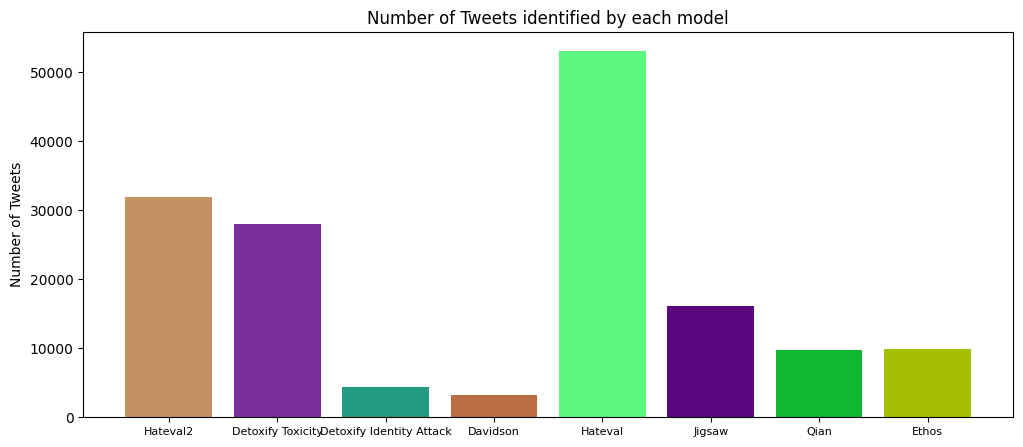

In [14]:
plot_data = [len(df[df["hateval2"] > 0.5]), len(df[df["toxicity"] > 0.5]),len(df[df["identity_attack"] > 0.5]), len(df[df["davidson"] > 0.5]),len(df[df["hateval"] > 0.5]),len(df[df["jigsaw"] > 0.5]) ,len(df[df["qian"] > 0.5]),len(df[df["ethos"] > 0.5])]
colors = []
for _ in range(len(plot_data)):
    colors.append((random.random(), random.random(), random.random())) 

plt.figure(figsize=(12,5))
plt.bar(range(len(plot_data)),plot_data, color=colors)
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets identified by each model")
plt.xticks(range(len(plot_data)), ['Hateval2','Detoxify Toxicity', 'Detoxify Identity Attack', 'Davidson', 'Hateval', 'Jigsaw', 'Qian', 'Ethos'], fontsize=8)

In [19]:
def sample_tweets(df, num=10):
    print(len(df))
    l = random.choices(df["clean"].tolist(), k=num)
    for sentence in l:
        print(sentence)

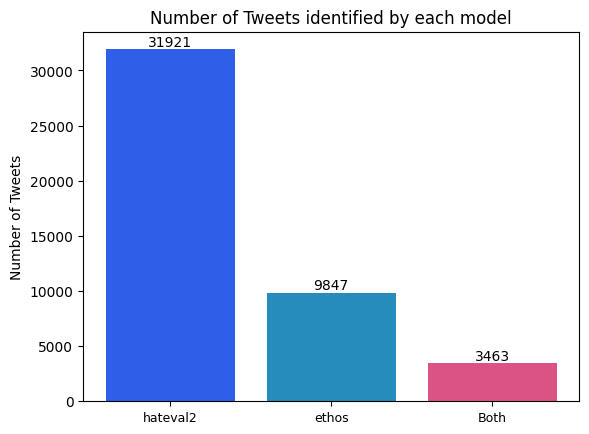

In [30]:
dataset1 = "hateval2"
dataset2 = "ethos"
plot_data = [
    len(df[df[dataset1] > 0.5]),
    len(df[df[dataset2] > 0.5]),
    len(df[(df[dataset1] > 0.5) & (df[dataset2] > 0.5)])
]
colors = [ (random.random(), random.random(), random.random()) for _ in range(len(plot_data)) ]

# plt.figure(figsize=(12,5))
bars = plt.bar(range(len(plot_data)), plot_data, color=colors)
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets identified by each model")
plt.xticks(range(len(plot_data)), [dataset1, dataset2, 'Both'], fontsize=9)

# Annotate bars with counts
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.show()

In [25]:
sample_tweets(df[(df[dataset1] > 0.9) & (df[dataset2] < 0.5)], num=20)
print("-----------------")
sample_tweets(df[(df[dataset2] > 0.9) & (df[dataset1] < 0.5)], num=20)

9330
Leave the drug lords and criminals alone and stop tempting them with your vulnerability and possessions
Good morning Mikhail and everyone Let s follow each other and grow Power to the People
Oh there s so many more leaving in the Bay Area Recruitment is way down and pretty much every agency is low If they drop the mandates a massive amount of people will leave Alameda tried but 100 of their 400 which is already short staffed said they would quit
Now I wonder how that happened Could it be because a world leader indicated that Chinese people were responsible for the spread of a deadly virus and essentially sicced his mob on Asians and Asian Americans
Well since the only money she has brought into our district is for sand in her backyard beach I suspect there is a likelihood of that sand getting a few patches
Please follow me
If we could all tell Asians apart all the time there would be no communist China Sometimes it pays to be able to tell who you are trying to assassinate Characte